### About

**NOTE: This notebook is a continuation of my previous notebook which contained EDA.**   

You can refer the following links:  
- Part-1 EDA: LINK  
- End-to-End implementation with deployment on AWS: https://github.com/Sharma-Ayush/Credit-Card-Fraud-Detection.git

### Objective of this notebook

The objective for this notebook is:  
- Feature Engineering.  
- Handling Imbalance.  
- Feature importance.  
- Cross-validation and hyper parameter tuning of classification models.  
- Testing on test set.

<u>PS:</u>  
- Feel free to contact me if you have any doubts or feedback through the comment section or my socials.
- Please upvote the notebook if you like it, as it would motivate me to develop more projects like these.

### My Socials

Follow me on these platforms, for more such content:  

LinkedIn: https://www.linkedin.com/in/ayush-sharma-660831125/  
Github: https://github.com/Sharma-Ayush  
Kaggle: https://www.kaggle.com/ayushsharma0812

### Import Required Libraries

In [96]:
# Data Manipulation
import numpy as np
import pandas as pd

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN, SMOTE
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc, precision_recall_curve
from sklearn.metrics._scorer import make_scorer

# extra modules
from warnings import filterwarnings
filterwarnings("ignore")


### Custom classes & functions

In [62]:
def double_log_transform(x):
    '''Transform x by taking the log of the data after shifting by 1. This operation is done two times iteratively.'''
    return np.log10(np.log10(x + 1) + 1)

def cube_root_transform(x):
    '''Transform x by taking the cube root of the data.'''
    return np.cbrt(x)

In [63]:
def area_under_precision_recall_curve(y_true, y_pred):
    '''Function that can compute the area under precision recall curve'''
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    auc_precision_recall = auc(recall, precision)
    return auc_precision_recall


In [78]:
def find_best_cv_params(X, Y, model_tuple, params, column_transformer, standard_scaler, resampler, scoring, score_name, n_iter = 25, search_type = 'random', cv = 5):
    '''Perform random search or grid search on given X and Y using given model & parameter distributions preceeded by column_trasnformer, standard_scaler & resampler.
    n_iter(for random search), cv(no. of splits), scoring(score for finding best params) can be passed as parameters.'''

    if resampler:
        training_pipeline = Pipeline([('column_transformer', column_transformer),
                                      ('standard_scaler', standard_scaler),
                                      ('resampler', resampler),
                                      model_tuple])
    else:
        training_pipeline = Pipeline([('column_transformer', column_transformer),
                                      ('standard_scaler', standard_scaler),
                                      model_tuple])
    
    if search_type == 'random':
        cross_validator = RandomizedSearchCV(training_pipeline,
                                             param_distributions = params,
                                             n_iter = n_iter,
                                             cv = cv,
                                             scoring = scoring,
                                             return_train_score = True,
                                             refit = False,
                                             error_score = 0,
                                             n_jobs = -1,
                                             random_state = 42)
    elif search_type == 'grid':
        cross_validator = GridSearchCV(training_pipeline,
                                       param_grid = params,
                                       scoring = scoring,
                                       cv = cv,
                                       n_jobs = -1,
                                       refit = False,
                                       error_score = 0,
                                       return_train_score = True)
    else:
        print('Invalid search type. Aborting.')
        return None

    cross_validator.fit(X, Y)
    print(f'For model - {model_tuple[0]} {search_type} search:')
    print('----------------------------------------------------------')
    print(f'Best mean {score_name}:')
    print(f'Train set: {np.round(max(cross_validator.cv_results_['mean_train_score']), 3)}')
    print(f'Validation set: {np.round(cross_validator.best_score_, 3)}')
    print('----------------------------------------------------------')

    if search_type == 'random':
        return cross_validator.best_params_
    elif search_type == 'grid':
        print(cross_validator.best_params_)
        return cross_validator.best_params_

In [101]:
def plot_boxplot_for_multi_num_cols(data, num_cols, target_col, color_mapping = None):
    '''Plot boxplot of numerical columns segregated per category of target_col with given color mapping for multiple numerical columns.'''
    
    # Calculate number of figures needed for 5 columns per figure or lesser
    no_of_figures = len(num_cols) // 5

    if len(num_cols) % 5 != 0:
        no_of_figures += 1

    # Plotting the histograms and density plots
    for i in range(no_of_figures):
        columns_to_plot = num_cols[i*5:(i+1)*5]

        fig, ax = plt.subplots(1, len(columns_to_plot), figsize = (len(columns_to_plot)*6, 4), sharex = True)

        for index, col in enumerate(columns_to_plot):

            if color_mapping != None:
                sns.boxplot(data, y = col, hue = target_col, ax = ax[index], palette = color_mapping)
            else:
                sns.boxplot(data, y = col, hue = target_col, ax = ax[index])
            ax[index].set_title(col)

        plt.subplots_adjust(wspace = 0.25)

        plt.show();

### Loading the dataset

In [65]:
df_train = pd.read_csv('Data/creditcard_train.csv')

### Handling imbalance

We have already seen the huge imbalance that exists within our dataset. We need to mitigate that imbalance, otherwise our model will focus more on the majority class(genuine transactions). There are many techniques that we can use:  

1. <u>Undersampling of majority class:</u> We take random sample of majority class so that the size matches that of minority class. This will reduce the dataset size which is good if we want reduced computation effort and thus, will lead to faster computation but at the same time it will lead to loss of information.  

2. <u>Oversampling of minority class:</u> We do random sampling on minority class with replacement so that the size of minority class matches that of majority class. This will increase dataset's size which will lead to more computational effort but will preserve information unlike undersampling. Duplicates are generated within minority class and this can lead to overfitting.  

3. <u>Synthetic data generation techniques:</u> We use techniques like SMOTE, its variants or ADASYN to oversample minority class in a systematic way by adding points in between existing minority class data points with some logic behind. This is the best way to upsample as duplication is not present but points are added along straight lines in between existing data points and this can lead to addition of artificial patterns. 

4. <u>Weight based sensitivity:</u> Many algorithms allow us to specify weights for each record of our dataset, we can specify higher weights to minority class records and the algorithm will focus more on them.

I would like to try both synthetic generation and weight based sensitivity, then compare them but the dataset is decently big in size and I want to perform cross-validaiton for hyper parameter tuning as well and thus, there is a problem here.  

When we generate cross-validation sets they should be first split up and then each of the set should be passed through the synthetic generator, any other transformations and then finally evaluated upon. This is done after splitting so that the information doesn't leak in between train and validation sets. To save time on computation and still do hyperparameter tuning which itself will be time taking, I want a technique of synthetic generation where the size of the resulting dataset is not too big because I don't have that much time and computation to spare on both - mulltiple synthetic generations and cross-validation.  

So, what should I do? Definitely, I can try weight based sensitivity as it is, because it does not involve any synthetic generation. Other option that I am thinking of is a combination of undersampling and ADASYN. If I was to undersample majority class all the way to same size as minority class then that will be too much loss of information. Due to my own time and computation constraints, I want to just reduce the size of majority class by enough and at the same time oversample minority class through synthetic generator such that the time taken for this process is managable.

I will use ADASYN. ADSYN tries to add more data towards the low density points of minority class. This means that even noisy points of fraudulent class will get attention and it might overfit a bit too much on the minority class i.e. it might perform very well on minority class but poorer on majority class. In a case like this of frauds and scams we want to primarily focus on predicting fraud cases as best as possible and even if some genuine cases(as long as its not too much above some threshold) are predicted to be as fraud we should be okay with it as the credi card issuer can provide tighter verification to user in these cases. This way we have tight leash on frauds which will save the company money and tighter verification for genuine cases predicted as fraud. If its too much overfitting we can try other techniques like SMOTE.

Undersampling will be done before training. I will choose a decent size of 10k for undersampling and then upsample minority class to this using ADASYN. Anyone who can spare time and computational effort on this can use the whole dataset as it is and upsample minority class, this will preserve information.

In [66]:
minority_class_size = df_train.Class.value_counts().min()

# Random under sampling the majority class to a size of 10000
X_resampled, Y_resampled = RandomUnderSampler(sampling_strategy = minority_class_size/10000, random_state = 42).fit_resample(df_train.drop(columns = 'Class'), df_train['Class'])

# ADASYN resampler fo synthetic generation of minority class
ADASYN_resampler = ADASYN(sampling_strategy = 'auto', random_state = 42)

### Feature Engineering

Based on the EDA notebook, I have to perform following transformations and manipulations on my dataset:  
- Take log10 Amount column after shiting the data by 1. This is done two times iteratively.  
- Drop 3 columns: V13, V15, and V23.  
- Take cube root of all the rest of PCA encoded columns.  

The order of the transformations will be as followed:  
- Transform columns based on EDA.  
- Standardize columns so that scales of columns are similar.  
- Then in the last use ADASYN for upsampling minority class.

In [85]:
# Define the columns to be transformed
double_log_transform_columns = ['Amount']
cube_root_transform_columns = ['V' + str(i) for i in range(1, 29) if i not in [13, 15, 23]]
passthrough_columns = ['Time']
drop_columns = ['V13', 'V15', 'V23']

# Define the functional transformers for the group of columns
double_log_transformer = FunctionTransformer(func = double_log_transform, feature_names_out = 'one-to-one')
cube_root_transformer = FunctionTransformer(func = cube_root_transform, feature_names_out = 'one-to-one')
pass_through_transformer = 'passthrough'

# Create transformers
column_transformer = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                        ('cube_root_transformer', cube_root_transformer, cube_root_transform_columns),
                                        ('passthrough', pass_through_transformer, passthrough_columns)],
                                        remainder = 'drop')
standard_scaler = StandardScaler()

### Predictive Modeling

**What metric to choose for evaluation?**  
Since its an imbalanced dataset, we can't use accuracy as an evaluation metric as that would be highly influenced by the majority class.  

If we were to work on this problem statement in a business setting, then we would have some criteria on precision and recall that the final model should achieve to be actually useful and deployed into production. Since we want to focus more on fraud to keep chargeback costs to lower amount, we would have had stricter criteria on recall so that the prediction within fraud class is quite good and a more relaxed criteria on precision meaning that we can allow more errors in genuine cases. But these are two metrics, how can we use two metrics to properly compare several models? That's why measures which combine these precision and recall into one measure are used for model comparison. Once the final model in decided based on this summarization measure, we can adjust the threshold on the soft probability to adjust precision and recall levels of the model. If then we are able to achieve precision and recall above our business criterias, we can go forward to deploying our model otherwise we go back to the drawing board.  

For evaluating, imbalanced datasets F1 score, area under the ROC and area under the precision-recall curve are common measures. For very high imbalanced dataset, precision-recall curve area is seen to be more sensitive and thus, better towards summarizing the performance. Therefore, F1 score or area under the precision-recall curve can be used here. As per the datasets author they have suggested to use area under precision-recall curve and that's what I will use here.

In [68]:
# Defining the evaluation metric scorer object
area_under_precision_recall_curve_scorer = make_scorer(area_under_precision_recall_curve, response_method = 'predict_proba', greater_is_better = True)

#### Experimenting with Logistic Regression

For experimental purpose, I will just use logistic regression model.  

I will try to see the following things:  
1. Class weight balancing vs ADASYN resampler  
2. Does column transformation have any effect on performance or not?

##### 1. Class weight balancing

In [79]:
# Performing random search cross-validation

find_best_cv_params(X_resampled,
                    Y_resampled,
                    ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    column_transformer, 
                    standard_scaler, 
                    None,
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.927
Validation set: 0.914
----------------------------------------------------------


{'Logistic_Regression__solver': 'sag',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.8),
 'Logistic_Regression__C': np.float64(0.012742749857031334)}

In [80]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_resampled,
                                  Y_resampled,
                                  ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                                  {'Logistic_Regression__penalty' : ['elasticnet'],
                                  'Logistic_Regression__C' : np.logspace(-3, -1, 10), 
                                  'Logistic_Regression__solver': ['saga'],
                                  'Logistic_Regression__l1_ratio': np.linspace(0.5, 0.95, 10, endpoint = True)}, 
                                  column_transformer, 
                                  standard_scaler, 
                                  None,
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.926
Validation set: 0.916
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.021544346900318832), 'Logistic_Regression__l1_ratio': np.float64(0.55), 'Logistic_Regression__penalty': 'elasticnet', 'Logistic_Regression__solver': 'saga'}


##### 2. ADASYN resampler

In [81]:
# Performing random search cross-validation

find_best_cv_params(X_resampled,
                    Y_resampled,
                    ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123)),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    column_transformer, 
                    standard_scaler, 
                    ADASYN_resampler,
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.753
Validation set: 0.728
----------------------------------------------------------


{'Logistic_Regression__solver': 'newton-cg',
 'Logistic_Regression__penalty': None,
 'Logistic_Regression__l1_ratio': np.float64(0.1),
 'Logistic_Regression__C': np.float64(1.623776739188721)}

Seems like its undefitting, even though the logistic regression model has no regularization i.e. the complexity of model is at its maximum it can be. Does it mean that using ADASYN has introduced artificial noise thus making the patterns complexer? Because if data has become more complex and model is simpler that would lead to underfitting. Maybe we can also play with parameters of ADASYN and hope things change but I won't try this here. Rather I want to try SMOTE.

##### 3. SMOTE resampler

In [83]:
SMOTE_resampler = SMOTE(random_state = 42)

# Performing random search cross-validation

find_best_cv_params(X_resampled,
                    Y_resampled,
                    ('Logistic_Regression', LogisticRegression(n_jobs = -1, random_state = 123)),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    column_transformer, 
                    standard_scaler, 
                    SMOTE_resampler,
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.925
Validation set: 0.912
----------------------------------------------------------


{'Logistic_Regression__solver': 'sag',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.8),
 'Logistic_Regression__C': np.float64(0.012742749857031334)}

SMOTE tends to work much better than ADASYN in this problem statement. ADASYN tries to add artificial points more and more near  the exisitng points which are farther from the center of minority class i.e. points which are mostly surrounded by majority class points. But what if these points are pure noisy points which we don't want to focus on then ADASYN will force us to focus on those points unnecessarily and this will affect our performance. SMOTE on the other hand adds new points randomly.

In [84]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_resampled,
                                  Y_resampled,
                                  ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                                  {'Logistic_Regression__penalty' : ['elasticnet'],
                                  'Logistic_Regression__C' : np.logspace(-3, -1, 10), 
                                  'Logistic_Regression__solver': ['saga'],
                                  'Logistic_Regression__l1_ratio': np.linspace(0.5, 0.95, 10, endpoint = True)}, 
                                  column_transformer, 
                                  standard_scaler, 
                                  SMOTE_resampler,
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.925
Validation set: 0.915
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.007742636826811269), 'Logistic_Regression__l1_ratio': np.float64(0.6), 'Logistic_Regression__penalty': 'elasticnet', 'Logistic_Regression__solver': 'saga'}


Class weight balancing performs slighlty better than SMOTE. Going on ahead we will work with class weight balancing only, this will reduce the need for resampling in our training pipeline. I can also increase my resampling size for the majority class and that will help in adding more information but I will stick with this for now.

##### 4. Class weight balancing without Amount column transformation

In [86]:
column_transformer_1 = ColumnTransformer([('cube_root_transform', cube_root_transformer, cube_root_transform_columns),
                                          ('drop', 'drop', drop_columns)],
                                          remainder = 'passthrough')

# Performing random search cross-validation

find_best_cv_params(X_resampled,
                    Y_resampled,
                    ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    column_transformer_1, 
                    standard_scaler, 
                    None,
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.923
Validation set: 0.914
----------------------------------------------------------


{'Logistic_Regression__solver': 'sag',
 'Logistic_Regression__penalty': 'l2',
 'Logistic_Regression__l1_ratio': np.float64(0.6),
 'Logistic_Regression__C': np.float64(0.08858667904100823)}

In [91]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_resampled,
                                  Y_resampled,
                                  ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                                  {'Logistic_Regression__penalty' : ['l2'],
                                  'Logistic_Regression__C' : np.logspace(-2, 0, 20), 
                                  'Logistic_Regression__solver': ['sag']}, 
                                  column_transformer_1, 
                                  standard_scaler, 
                                  None,
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.923
Validation set: 0.914
----------------------------------------------------------
{'Logistic_Regression__C': np.float64(0.026366508987303583), 'Logistic_Regression__penalty': 'l2', 'Logistic_Regression__solver': 'sag'}


There is only 0.2% decrease in AUC score for precision-recall curve.

##### 5. Class weight balancing without V1 to V28 column trasnformation

In [93]:
column_transformer_2 = ColumnTransformer([('double_log_transform', double_log_transformer, double_log_transform_columns),
                                          ('drop', 'drop', drop_columns)],
                                          remainder = 'passthrough')

# Performing random search cross-validation

find_best_cv_params(X_resampled,
                    Y_resampled,
                    ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                    {'Logistic_Regression__penalty' : ['l1', 'l2', 'elasticnet', None],
                     'Logistic_Regression__C' : np.logspace(-4, 4, 20), 
                     'Logistic_Regression__solver': ['lbfgs', 'newton-cg', 'sag', 'saga'],
                     'Logistic_Regression__l1_ratio': np.linspace(0.1, 1, 9, endpoint = False)}, 
                    column_transformer_2, 
                    standard_scaler, 
                    None,
                    area_under_precision_recall_curve_scorer,
                    'area under precision recall curve',
                    n_iter = 50)

For model - Logistic_Regression random search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.936
Validation set: 0.924
----------------------------------------------------------


{'Logistic_Regression__solver': 'lbfgs',
 'Logistic_Regression__penalty': None,
 'Logistic_Regression__l1_ratio': np.float64(0.6),
 'Logistic_Regression__C': np.float64(206.913808111479)}

In [94]:
# Performing grid search cross-validation

best_params = find_best_cv_params(X_resampled,
                                  Y_resampled,
                                  ('Logistic_Regression', LogisticRegression(class_weight = 'balanced', n_jobs = -1, random_state = 123)),
                                  {'Logistic_Regression__penalty' : [None],
                                  'Logistic_Regression__solver': ['lbfgs']}, 
                                  column_transformer_2, 
                                  standard_scaler, 
                                  None,
                                  area_under_precision_recall_curve_scorer,
                                  'area under precision recall curve',
                                  search_type = 'grid')

For model - Logistic_Regression grid search:
----------------------------------------------------------
Best mean area under precision recall curve:
Train set: 0.936
Validation set: 0.924
----------------------------------------------------------
{'Logistic_Regression__penalty': None, 'Logistic_Regression__solver': 'lbfgs'}


The model performance has improved from before when the transformations were performed. The transformation was done from the persepective that even extreme points should have similar weightage when it comes to training so that the algorithm can perform better throughout the range of these predictor features but this increase in performance implies that these extreme points on which when we focussed more lead to poorer performance could actually be outliers which don't follow similar pattern as majority of data points. Thus, we could try outlier detection and drop those extreme points as that will remove these points which follow different pattern completely and algorithm can solely focus on good points. Thus, that should help imrove performance further.  
This could also potentially connect with what we saw for ADASYN, I inferred that there are noisy points in the fardulent class and they are not important for prediction and thus, can be said as outliers which can be dropped as concluded above as well.

##### 6. Outlier detection and dropping

Lets first visualize the distirbutions of each column using boxplot segregated by target classes.

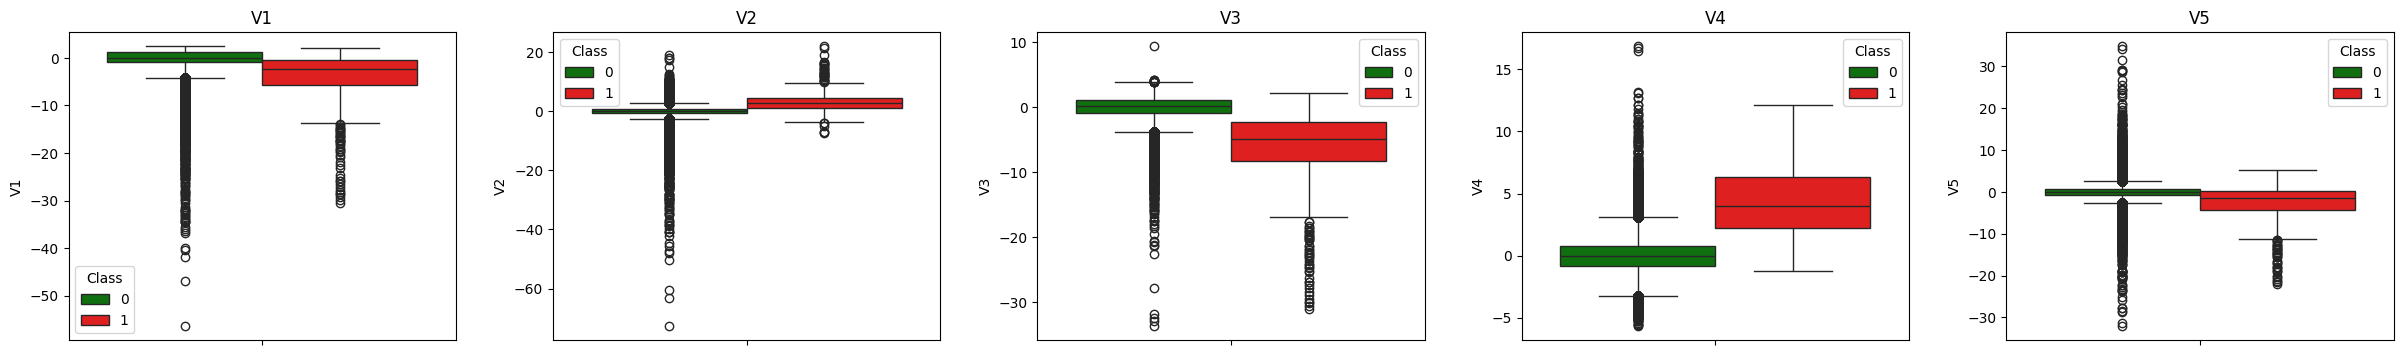

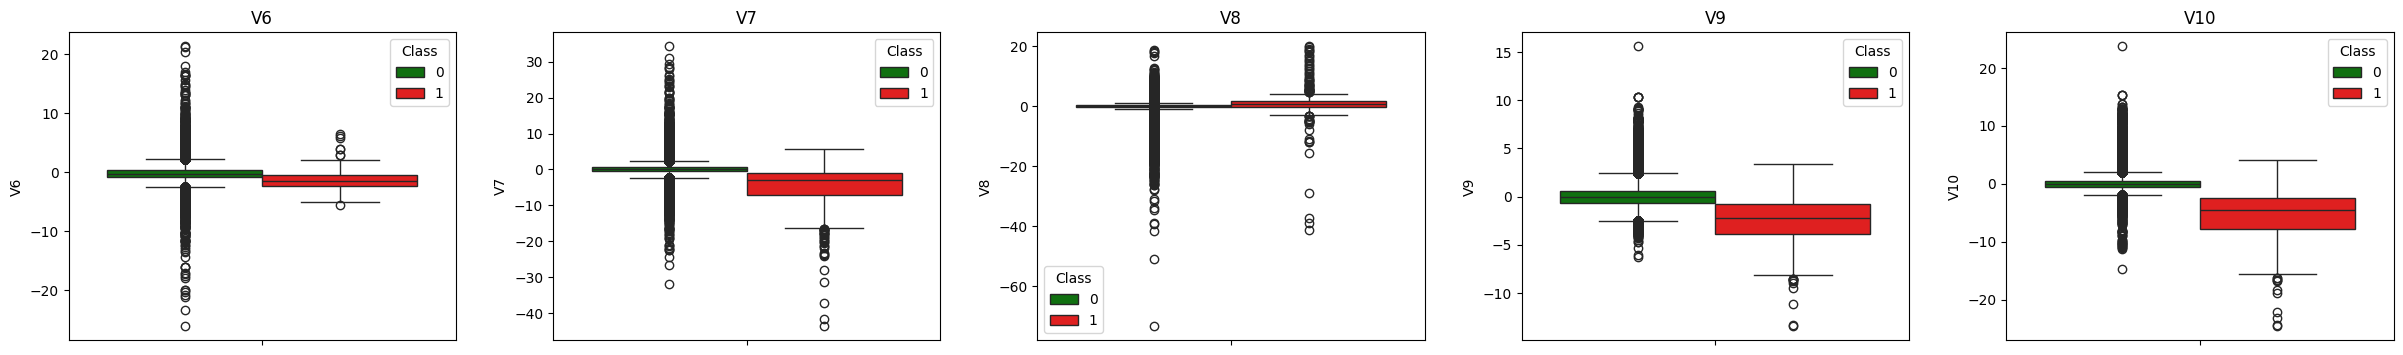

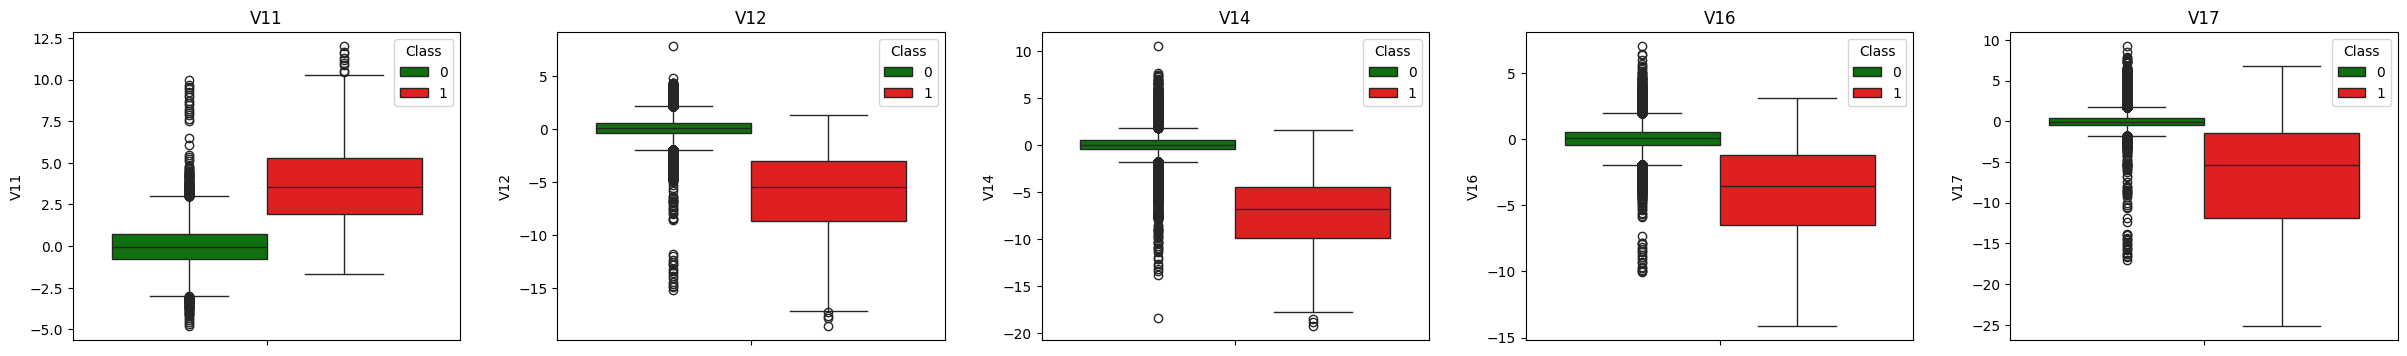

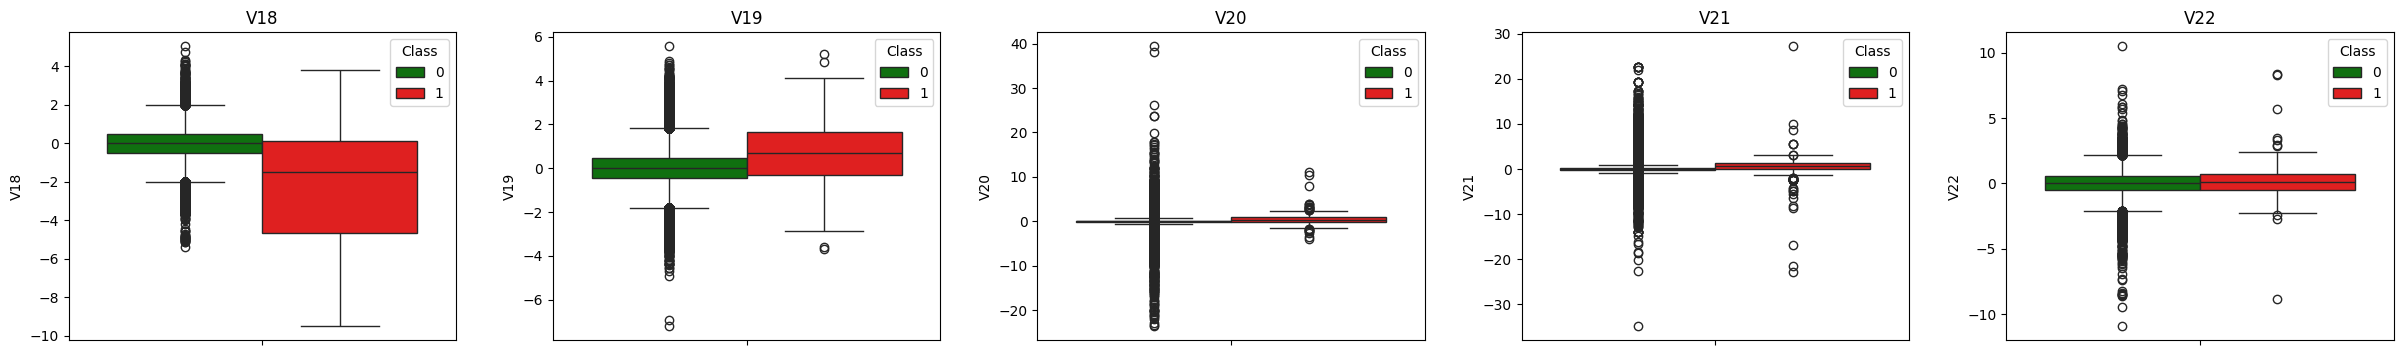

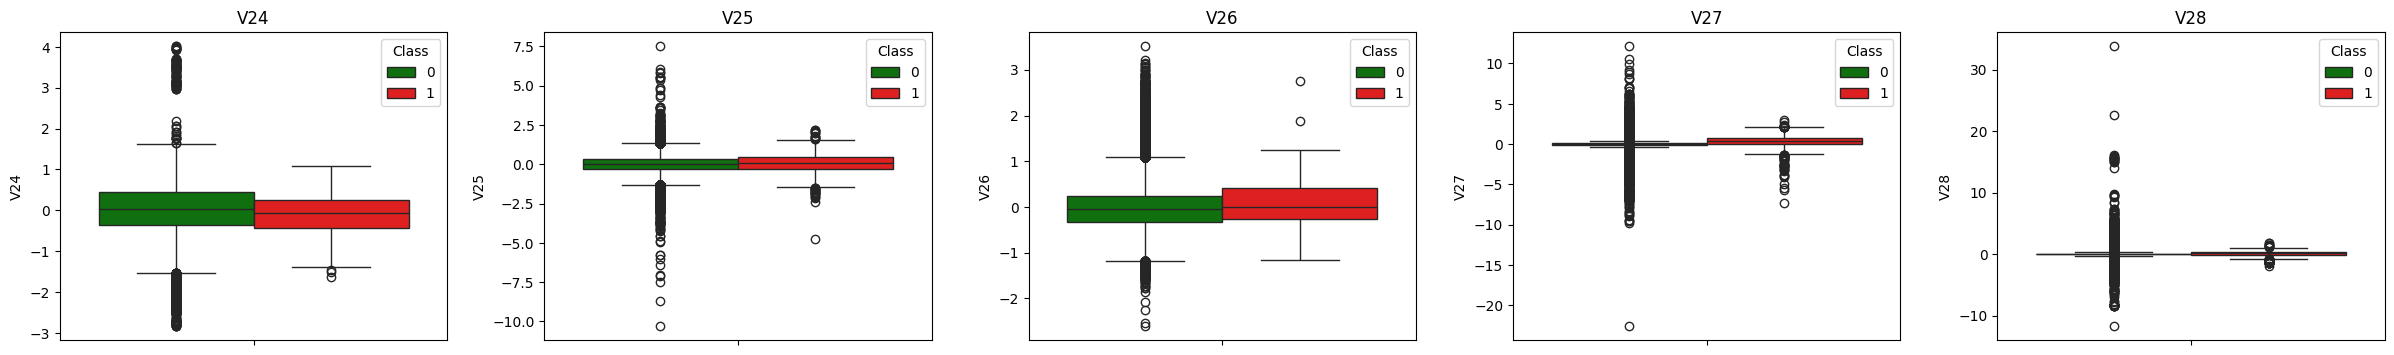

In [102]:
plot_boxplot_for_multi_num_cols(df_train, cube_root_transform_columns, 'Class', color_mapping = {0: 'green', 1: 'red'})

### References

- https://www.kdnuggets.com/2023/01/7-smote-variations-oversampling.html
- https://www.analyticsvidhya.com/blog/2020/10/overcoming-class-imbalance-using-smote-techniques/#h-dealing-with-imbalanced-data
- https://scikit-learn.org/stable/
- https://www.youtube.com/@krishnaik06  
- Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron